In [1]:
import torch
import util
import custum_dataset
from torch.utils.data import DataLoader
from model import Model,save_model
import torch.optim.lr_scheduler as lr_scheduler


# 1. setting up

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = f'C:/Users/yy/Desktop/dl_project/data/data.txt'  

save_model_bool = True
load_model_path = f"models/300epoch_model.pth"



c = util.config()

data_train,stoi,itos = util.load_data_with_split(path,c.split,type='train')
data_test,_,_ = util.load_data_with_split(path,c.split,type='test')


dataset_train = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_train,repeat = False)
data_loader_train = DataLoader(dataset_train, c.batch_size, shuffle=False)

dataset_test = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_test,repeat = False)
data_loader_test = DataLoader(dataset_test, c.batch_size, shuffle=False)

m = Model(stoi=dataset_train.stoi).to(device)


optimizer = torch.optim.Adam(m.parameters(), lr=c.learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.1, patience=5)



# 2. Training loop
lr decay: https://pytorch.org/docs/stable/optim.html

In [3]:
if save_model_bool:
    train_loss = []
    test_loss = []
    perplexity_train = []
    perplexity_test = []

    num_epochs = 4000
    MODEL_NAME = str(num_epochs)+"epoch_model.pth"


    for epoch in range(num_epochs):

        m.train()

        inputs, targets = next(iter(data_loader_train))

        optimizer.zero_grad()
        
        logit, loss, perplexity = m(inputs, use='train', y=targets)

        loss.backward()
        optimizer.step()
            

        # eval 
        m.eval()

        with torch.inference_mode():
            inputs_t, targets_t = next(iter(data_loader_test))

            # Forward pass
            logit, valid_loss, valid_perplexity = m(inputs, use='train', y=targets)

        if epoch%50 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}, Perplexity: {perplexity:.4f}")
            print(f"Validation Loss: {valid_loss:.4f}, Validation Perplexity: {valid_perplexity:.4f}")


        train_loss.append(loss.cpu().detach().numpy())
        test_loss.append(valid_loss.cpu().detach().numpy())
        perplexity_train.append(perplexity.cpu().detach().numpy())
        perplexity_test.append(valid_perplexity.cpu().detach().numpy())

        scheduler.step(valid_loss)

    save_model(m, MODEL_NAME)

else: 
    m.load_state_dict(torch.load(load_model_path))
    m.to(device)



Epoch 1/4000, Loss: 4.3740, Perplexity: 79.3606
Validation Loss: 3.9725, Validation Perplexity: 53.1195
Epoch 51/4000, Loss: 0.9986, Perplexity: 2.7146
Validation Loss: 0.9055, Validation Perplexity: 2.4732
Epoch 101/4000, Loss: 0.0935, Perplexity: 1.0980
Validation Loss: 0.0839, Validation Perplexity: 1.0876
Epoch 151/4000, Loss: 0.0231, Perplexity: 1.0234
Validation Loss: 0.0227, Validation Perplexity: 1.0229
Epoch 201/4000, Loss: 0.0225, Perplexity: 1.0228
Validation Loss: 0.0223, Validation Perplexity: 1.0226
Epoch 251/4000, Loss: 0.0227, Perplexity: 1.0230
Validation Loss: 0.0223, Validation Perplexity: 1.0226
Epoch 301/4000, Loss: 0.0234, Perplexity: 1.0237
Validation Loss: 0.0223, Validation Perplexity: 1.0226
Epoch 351/4000, Loss: 0.0231, Perplexity: 1.0233
Validation Loss: 0.0223, Validation Perplexity: 1.0226
Epoch 401/4000, Loss: 0.0232, Perplexity: 1.0235
Validation Loss: 0.0223, Validation Perplexity: 1.0226
Epoch 451/4000, Loss: 0.0235, Perplexity: 1.0238
Validation Loss:

# 3. Plotting loss and perplexity

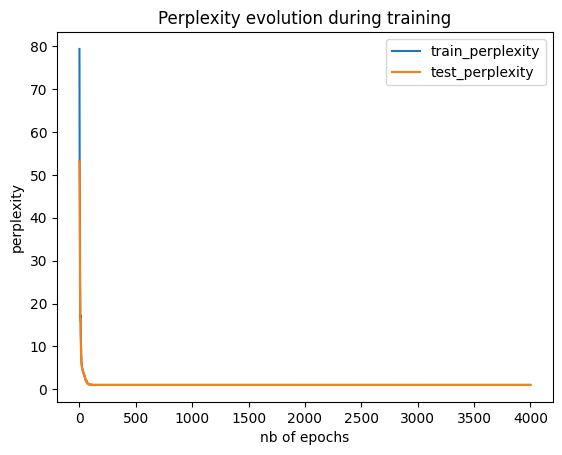

In [4]:
import matplotlib.pyplot as plt
import numpy as np
if save_model_bool:
    epoch_list = np.arange(0,len(train_loss))
    plt.plot(epoch_list,perplexity_train)
    plt.plot(epoch_list,perplexity_test)
    plt.title('Perplexity evolution during training')
    plt.legend(['train_perplexity','test_perplexity'])
    plt.xlabel('nb of epochs')
    plt.ylabel('perplexity')

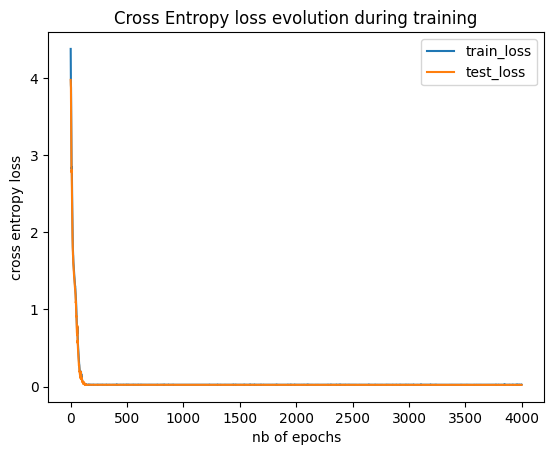

In [5]:
if save_model_bool:
    epoch_list = np.arange(0,len(train_loss))
    plt.plot(epoch_list,train_loss)
    plt.plot(epoch_list,test_loss)
    plt.title('Cross Entropy loss evolution during training')
    plt.legend(['train_loss','test_loss'])
    plt.xlabel('nb of epochs')
    plt.ylabel('cross entropy loss')



# 4. Generation:

In [6]:
nb_char = 3000

seed = "I saw a cat jumping onto the table, "
input_idx = util.encode(seed,stoi)

input_idx = torch.tensor(input_idx,dtype=torch.long)
input_idx = torch.unsqueeze(input_idx, 0).to(device)


In [7]:
m.eval()
with torch.no_grad():
    out = m.generate(nb_char,input_idx,'sample')
    out = util.decode(out,itos)
    

util.save_generated_text('output'+str(nb_char)+'_sample.txt',out)

In [9]:
m.eval()
with torch.no_grad():
    out = m.generate(nb_char,input_idx,'high_prob')
    out = util.decode(out,itos)
util.save_generated_text('output'+str(nb_char)+'_high_prob.txt',out)




KeyboardInterrupt: 